In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("L3_COMBO.xlsx")

final_merged_df = df.groupby('Stock Code', as_index=False)['ZSCORE_FINAL'].mean()

final_merged_df.head(40)

column_list = final_merged_df['Stock Code'].tolist()
# print(column_list)



In [3]:
df = pd.read_csv("C:/Users/meets/AVENTUS_FACTOR-MODEL/SIMPLE STRATEGY/mega_dateclose_final.csv")
columns_to_keep = ['Date'] + [col for col in column_list if col in df.columns]
filtered_with_date_df = df[columns_to_keep]


filtered_with_date_df['Date'] = pd.to_datetime(filtered_with_date_df['Date'])
start_date = pd.to_datetime("2021-03-31")
end_date = pd.to_datetime("2024-04-02")
filtered_df = filtered_with_date_df[(filtered_with_date_df['Date'] >= start_date) & (filtered_with_date_df['Date'] <= end_date)]
filtered_df.head()


df_cleaned = filtered_df.dropna(how='all', subset=filtered_df.columns.difference(['Date']))
rows_removed = len(filtered_df) - len(df_cleaned)
# print("ROWS REMOVED i.e. ALL VALUES MISSING EXCEPT DATE:", rows_removed)
df_cleaned.head()


df_fully_cleaned = df_cleaned.dropna(axis=1)
final_columns = df_fully_cleaned.columns.tolist()
if 'Date' in final_columns:
    final_columns.remove('Date')
print(final_columns)
df_fully_cleaned.head()


df_fully_cleaned['Date'] = pd.to_datetime(df_fully_cleaned['Date'])
df_fully_cleaned.set_index('Date', inplace=True)
pct_change_df = df_fully_cleaned.pct_change() 
pct_change_df = pct_change_df.iloc[1:] 
pct_change_df.head()
# pct_change_df.to_csv("gptwork.csv",index=False)



pct_change_df = pct_change_df.reset_index()  # This moves 'Date' from index to a regular column
pct_change_df.head()
# pct_change_df.to_csv("data1.csv",index=False) 





# pct_change_df.to_csv("deletenow.csv",index=False)
# nan_counts = pct_change_df.isna().sum()
# print(nan_counts)
# columns_without_nans = df.columns[df.isna().sum() == 0].tolist()
# print(columns_without_nans)

# pct_change_df.dropna

['ABFRL', 'ASTERDM', 'BALAXI', 'BATAINDIA', 'BLUEDART', 'CGPOWER', 'CREDITACC', 'DOLATALGO', 'GODREJAGRO', 'GODREJIND', 'HAPPSTMNDS', 'ITI', 'KESORAMIND', 'NURECA', 'RAJESHEXPO', 'RESPONIND', 'SFL', 'SPARC', 'SWANENERGY', 'ZYDUSWELL']


C:\Users\meets\AppData\Local\Temp\ipykernel_44640\3131278506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_with_date_df['Date'] = pd.to_datetime(filtered_with_date_df['Date'])


,Date,ABFRL,ASTERDM,BALAXI,BATAINDIA,BLUEDART,CGPOWER,CREDITACC,DOLATALGO,GODREJAGRO,...,HAPPSTMNDS,ITI,KESORAMIND,NURECA,RAJESHEXPO,RESPONIND,SFL,SPARC,SWANENERGY,ZYDUSWELL
0,2021-04-01,-0.011429,0.008003,0.050048,0.013405,0.003023,0.027653,-0.005740,0.012178,-0.011073,...,0.100917,0.019139,0.088256,0.000749,0.028300,0.089767,0.005665,0.071052,0.011066,0.006822
1,2021-04-05,-0.058809,-0.011187,0.028143,-0.019999,-0.039026,-0.033455,-0.054356,-0.029724,-0.020656,...,0.040787,-0.020487,-0.035317,0.121197,-0.020819,-0.049423,0.059451,0.041708,-0.001094,0.013199
2,2021-04-06,0.013618,0.007299,0.008830,-0.004726,-0.006765,0.049661,-0.021803,-0.028446,-0.005027,...,0.079913,0.001307,0.030508,0.028396,-0.002593,-0.008377,0.014765,0.021438,-0.013514,0.031797
3,2021-04-07,0.009484,-0.021377,0.049891,-0.001547,0.001874,0.049462,0.004944,0.004505,0.002576,...,0.005911,0.008268,0.013816,-0.019465,-0.001352,0.064958,-0.008327,0.015123,0.006294,0.005662
4,2021-04-08,-0.009916,0.007775,0.001251,0.012538,-0.014617,0.049863,-0.008468,0.034380,0.001877,...,-0.011381,0.006474,-0.001298,0.039850,0.051853,-0.045952,-0.001746,-0.016418,-0.001840,-0.005630


In [4]:
# PORTFOLIO WT CALCULATION

final_df = final_merged_df[final_merged_df['Stock Code'].isin([name.upper() for name in final_columns])]
final_df.head()



# Step 1: Initial weights from Z-score
final_df['PORTFOLIO_WEIGHTS'] = final_df["ZSCORE_FINAL"] / final_df["ZSCORE_FINAL"].sum()

# Step 2: Cap and redistribute iteratively
cap = 0.07
weights = final_df['PORTFOLIO_WEIGHTS'].copy()

while True:
    over_cap = weights > cap
    if not over_cap.any():
        break  # Exit loop if no weights are over the cap

    # Cap the overweight stocks
    weights[over_cap] = cap

    # Redistribute the excess weight
    total_weight = weights.sum()
    excess = 1.0 - total_weight

    # Identify stocks eligible to receive excess (not capped)
    under_cap = weights < cap
    allocatable = weights[under_cap]
    scaling_sum = allocatable.sum()

    if scaling_sum == 0:
        break  # Avoid divide by zero

    # Distribute excess proportionally
    weights[under_cap] += (allocatable / scaling_sum) * excess

final_df['PORTFOLIO_WEIGHTS'] = weights

# Final checks (optional)
print("Max weight:", final_df['PORTFOLIO_WEIGHTS'].max())  # Should be <= 0.07
print("Total weight:", final_df['PORTFOLIO_WEIGHTS'].sum())  # Should be ~1.0


final_df = final_df[["Stock Code","PORTFOLIO_WEIGHTS"]]
final_df.head(20)


final_df.to_csv("L3_COMBO_OP_NEW.csv",index=False)

Max weight: 0.07
Total weight: 1.0000000000000002


In [5]:
#DIRECT COPYPASTE - NO EDIT


# Align columns: ensure weights match the columns in the return dataframe
returns_df = pct_change_df.copy()
weights_df = final_df.set_index("Stock Code")["PORTFOLIO_WEIGHTS"]

# Ensure only common stocks are used
common_stocks = returns_df.columns.intersection(weights_df.index)
returns_matrix = returns_df[common_stocks].copy()
weights_vector = weights_df.loc[common_stocks]

# Perform matrix multiplication (dot product) for each date
returns_df["Portfolio Return"] = returns_matrix.dot(weights_vector)

# Show a few results
final_portfolio = returns_df[["Date", "Portfolio Return"]]
final_portfolio.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              745 non-null    datetime64[ns]
 1   Portfolio Return  745 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.8 KB


In [6]:
#DIRECT COPYPASTE - NO EDIT

df2 = pd.read_csv("C:/Users/meets/AVENTUS_FACTOR-MODEL/SIMPLE STRATEGY/BENCHMARK/BSE500_PCTRETURNS_09-25.csv")
df2['BDP_Date'] = pd.to_datetime(df2['BDP_Date'])

final_portfolio_benchmark = pd.merge(final_portfolio, df2, how='inner', left_on='Date', right_on='BDP_Date')
final_portfolio_benchmark = final_portfolio_benchmark.drop('BDP_Date', axis=1)
final_portfolio_benchmark.set_index('Date', inplace=True)
final_portfolio_benchmark = final_portfolio_benchmark.rename(columns={'Portfolio Return':'Strategy'})
final_portfolio_benchmark.head()
final_portfolio_benchmark.to_csv("L3_COMBO_FINAL_NEW.csv")
# final_portfolio_benchmark.to_csv("final_portfolio_benchmarkQ.csv")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2021-04-01   2021-04-01
End Period                 2024-04-02   2024-04-02
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          65.87%       79.22%
CAGR﹪                     12.33%       14.34%

Sharpe                     1.31         1.18
Prob. Sharpe Ratio         98.51%       97.52%
Smart Sharpe               1.23         1.11
Sortino                    1.8          1.61
Smart Sortino              1.7          1.52
Sortino/√2                 1.27         1.14
Smart Sortino/√2           1.2          1.07
Omega                      1.23         1.23

Max Drawdown               -18.35%      -22.42%
Longest DD Days            407          599
Volatility (ann.)          13.83%       18.16%
R^2                        0.53         0.53
Information Ratio          0.02         0.02
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-18,2023-03-28,2023-09-08,599,-22.415533,-20.846910
2,2024-02-21,2024-03-13,2024-04-02,42,-14.594749,-11.880980
3,2021-11-10,2021-11-30,2021-12-30,51,-7.948412,-7.701807
4,2021-08-04,2021-08-23,2021-09-13,41,-6.250706,-5.515092
5,2021-10-19,2021-10-25,2021-11-08,21,-4.856222,-4.795040


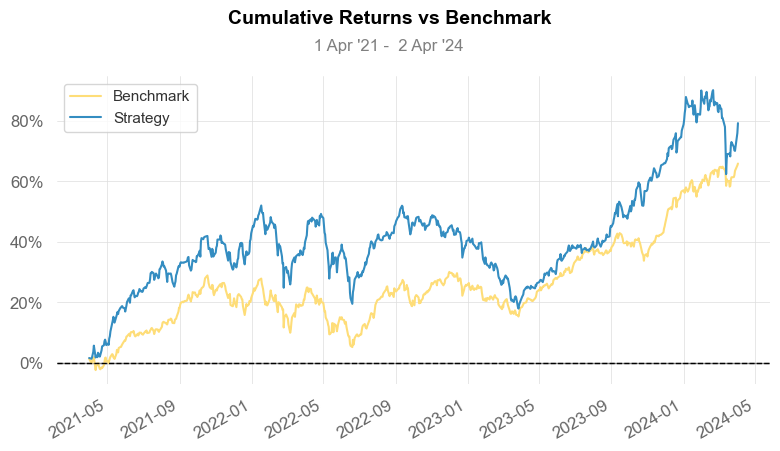

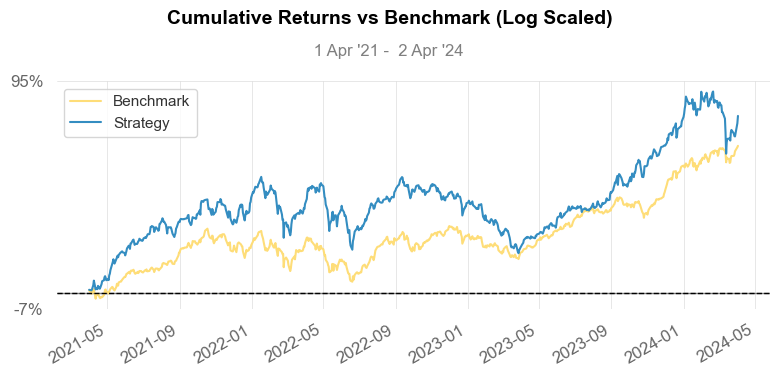

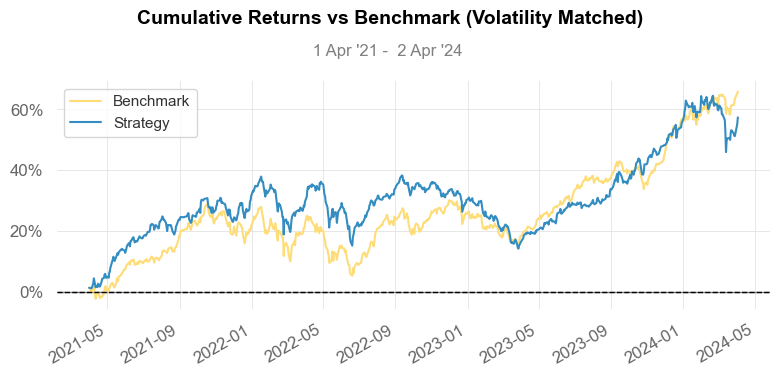

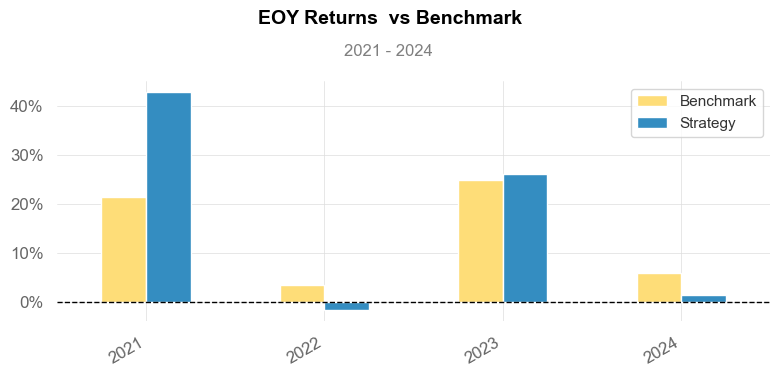

OptionError: No such keys(s): 'mode.use_inf_as_null'

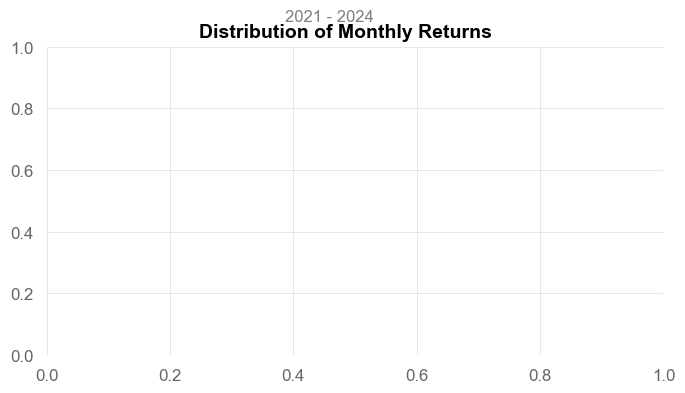

In [7]:
import quantstats as qs

final_portfolio_benchmark.index = pd.to_datetime(final_portfolio_benchmark.index)

qs.reports.full(final_portfolio_benchmark['Strategy'],benchmark = final_portfolio_benchmark['BDP_Close'],mode="full")